In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import pathlib
import config as cfg

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

import copy

from save_results import save_results_smart, list_saved_configs

/home/nad/studies/Transformer-Image-Captioning-IIW/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(cfg)
torch.cuda.empty_cache()

In [3]:
# Setup device-agnostic code
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model_folder = cfg.CONFIG_ROOT / "results/config_20260121-200819"
config = cfg.import_config(model_folder / 'config.json')
model_path = model_folder / 'cptr_model.pth'

In [5]:
batch_size_train = config["BATCH_SIZE_TRAIN"]
batch_size_test = config["BATCH_SIZE_TEST"]

H = config["IMG_HEIGHT"]
W = config["IMG_WIDTH"]
P = config["PATCH_SIZE"]
D_IMG = config["IMG_EMBEDDING_DIM"]

# The data will get truncated/padded to this length AFTER tokenization
L = config["MAX_TEXT_SEQUENCE_LENGTH"]
D_TEXT = config["TEXT_EMBEDDING_DIM"]
DROPOUT_DEC = config["DECODER_DROPOUT_PROB"]
RANDOM_SEED = config["RANDOM_SEED"]

In [6]:
data_loader = DatasetLoader(dataset_type=config["DATASET"],
                            img_height=H,
                            img_width=W,
                            batch_size_train=batch_size_train, 
                            batch_size_test=batch_size_test,
                            split_ratio=config["SPLIT_RATIO"],
                            shuffle_test=True,
                            seed=RANDOM_SEED)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

Loading Flickr30k dataset...
DatasetDict({
    test: Dataset({
        features: ['image', 'description'],
        num_rows: 31014
    })
})


In [7]:
special_tokens = [cfg.SpecialTokens.PAD, cfg.SpecialTokens.BOS, cfg.SpecialTokens.EOS]
if config["TOKENIZER_TYPE"] == cfg.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config["TOKENIZER_TYPE"] == cfg.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config["TOKENIZER_DATA_PATH"], filename_prefix=config["TOKENIZER_FILENAME_PREFIX"])
    
pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()
print(f"Tokenizer vocab size: {vocab_size}, Pad token ID: {pad_idx}")

Tokenizer vocab size: 9965, Pad token ID: 0


In [8]:
transformer = CPTR(num_patches=config["NUM_PATCHES"],
                   encoder_arch=config["ENCODER_ARCH"],
                   encoding_strategy=config["VIT_ENCODING_STRATEGY"],
                   use_embedding_projection=config["USE_PROJECTION_LAYER"],
                   img_emb_use_conv=config["USE_CONV_IMG_EMBEDDING"],
                   img_emb_dim=config["IMG_EMBEDDING_DIM"],
                   patch_size=config["PATCH_SIZE"],
                   text_emb_dim=config["TEXT_EMBEDDING_DIM"],
                   d_model=config["EMBEDDING_DIM"],
                   max_text_seq_len=config["MAX_TEXT_SEQUENCE_LENGTH"],
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   channels=config["NUM_INPUT_CHANNELS"],
                   num_encoder_blocks=config["ENCODER_NUM_BLOCKS"],
                   num_encoder_heads=config["ENCODER_NUM_HEADS"],
                   encoder_hidden_dim=config["ENCODER_HIDDEN_DIM"],
                   encoder_dropout_prob=config["ENCODER_DROPOUT_PROB"],
                   num_decoder_blocks=config["DECODER_NUM_BLOCKS"],
                   num_decoder_heads=config["DECODER_NUM_HEADS"],
                   decoder_hidden_dim=config["DECODER_HIDDEN_DIM"],
                   decoder_dropout_prob=config["DECODER_DROPOUT_PROB"],
                   bias=config["USE_BIAS"],
                   use_weight_tying=config["USE_WEIGHT_TYING"],
                   sublayer_dropout=config["SUBLAYER_DROPOUT"],
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))
transformer.eval()

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


CPTR(
  (encoder): ViTEncoder(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): Linear(in_features=768, o

Caption GT:  A woman wearing black clothing is standing next to a man who is looking at something in his hands.
Input image shape: torch.Size([1, 3, 224, 224])


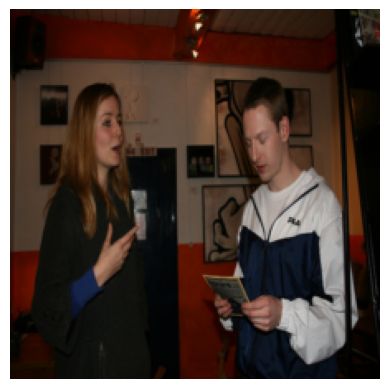

Generated token ids: tensor([   1,  321,  295,  793, 2215, 1891,  103,  109,  706,  311,  440, 1970,
        3535, 1618,  287,  356, 1018,  453,  104, 1346, 1139,  414,  408,  388,
        1785,  813,  993,  294,  341,  263,  823, 1875,  344, 1035, 1227, 1314,
         273,  549,  113, 1696,  824,  979, 2256,  853, 1228,  373, 2303, 1751,
         827,  760,  645,  807, 1202, 5459,  547,  783, 1812, 1867, 2997,  701,
         421, 2735, 1144,  260,  851,  342,  272,  428,  376,  338,  751, 2905,
         374,  730,  371, 2326, 1048,  396,  656,  815,  416, 1979,  747,  563,
         864,  748,  415, 1679,  326,  809,  306,  368,  292, 1052,  526, 1383,
         296,  982,  557, 1463,  483, 2140, 1332,  510, 5240, 3029,  259, 4035,
         627,  531,  288,  422,  746,  102,  298,  638,  337,    2])
torch.Size([118])
Generated caption: <bos> yen about fencing predj bicycleon yellow froarm cralassroom wheys stairs stream her you cancoal bath awaylin stand G overlooking wet phoneniqudsome

In [9]:
batch = next(iter(train_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
print('Generated token ids:', tokens)
print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


Caption GT:  Two women in shorts and protective equipment bumping into each other.
Input image shape: torch.Size([1, 3, 224, 224])


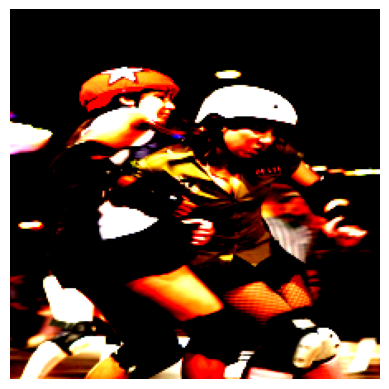

Generated token ids: tensor([  1,  68, 433, 292, 412, 259, 269, 370, 264, 341, 118, 110, 310, 504,
        270, 275, 277, 280, 122, 103,  49,   2])
torch.Size([22])
Generated caption: <bos>A group of men are playing basketball in the crowd.<eos>


In [85]:
batch = next(iter(test_dataloader))
image = batch["pixel_values"][0].unsqueeze(0).to(device)
print('Caption GT: ', batch["description"][0])
print('Input image shape:', image.shape)
# plot input image
img = image[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')
plt.show()

tokens = transformer.generate(image, 
        bos_token=tokenizer.get_vocab()[cfg.SpecialTokens.BOS.value],
        eos_token=tokenizer.get_vocab()[cfg.SpecialTokens.EOS.value],
        max_len=L,
        device=device,
        used_tokens_penalty=True)
if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
print('Generated token ids:', tokens)
print(tokens.shape)
decoded_caption = tokenizer.decode(tokens)
print('Generated caption:', decoded_caption)